<a href="https://colab.research.google.com/github/ElvisRojasM/Construction-of-Socioeconomic-Indicators-Using-Python/blob/main/2_Manejo_de_datos_de_series_de_tiempo_extracciones%2C_limpienza_y_regresiones_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Manejo de datos de series de tiempo: extracciones, limpienza y regresiones

- **Extracción de Datos**:
   - Se extraen datos de series de tiempo a través de la API del Banco Central de Reserva del Perú (BCRP).

- **Desestacionalización de Datos**:
   - Se aplica el método Census X-13 para desestacionalizar los datos.

- **Transformación a Primeras Diferencias**:
   - Las series se transforman en primeras diferencias siguiendo criterios de estacionariedad determinados mediante pruebas de raíces unitarias.

- **Visualización de Datos**:
   - Se generan gráficos para visualizar las series de tiempo.

- **Análisis de Datos**:
   - Se realizan regresiones lineales para el análisis de los datos desestacionalizados y transformados.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; from matplotlib.ticker import FormatStrFormatter
import scipy.stats as st
import requests
from io import StringIO
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import zivot_andrews
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from functools import reduce


In [2]:
pip install arch

In [3]:
def get_data_bcrp(Code, StartDate, EndDate, Freq, ColName):

    link = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api/" + Code + "/csv/" + StartDate + "/" + EndDate
    print(link)
    content_var = requests.get(link,
                               verify = False).text.replace("<br>","\n").strip()
    print()
    csv_var     = StringIO(content_var)
    df          = pd.read_csv(csv_var)

    if Freq == 'Q': # to data in quarterly frequency
        StartDate_mod = StartDate.split('-')[0] + '-' + str( (int(StartDate.split('-')[-1]))*2 + int(StartDate.split('-')[-1]))
        df.index      = pd.date_range(start = StartDate_mod, freq = Freq, periods = len(df))
        df           = df.drop(df.columns[0],axis=1); df.columns  = [ColName]
    else: # to data in monthly frequency
        df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))
        df            = df.drop(df.columns[0],axis=1); df.columns  = [ColName]

    return df

In [4]:
import os
os.environ["X13PATH"] = "/content/x13as/"
# Instala statsmodels mais atual
#!pip install statsmodels=-0.13.5
# Importa o módulo
from statsmodels.tsa import x13

!wget    https://www2.census.gov/software/x-13arima-seats/x13as/unix-linux/program-archives/x13as_ascii-v1-1-b60.tar.gz

!tar  --gunzip --extract --verbose --file=x13as_ascii-v1-1-b60.tar.gz


--2025-02-22 02:41:40--  https://www2.census.gov/software/x-13arima-seats/x13as/unix-linux/program-archives/x13as_ascii-v1-1-b60.tar.gz
Resolving www2.census.gov (www2.census.gov)... 23.63.174.207, 2600:1406:bc00:681::208c, 2600:1406:bc00:695::208c
Connecting to www2.census.gov (www2.census.gov)|23.63.174.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3784090 (3.6M) [application/x-tar]
Saving to: ‘x13as_ascii-v1-1-b60.tar.gz.1’

x13as_ascii-v1-1-b6 100%[===================>]   3.61M  1.77MB/s    in 2.0s    

2025-02-22 02:41:42 (1.77 MB/s) - ‘x13as_ascii-v1-1-b60.tar.gz.1’ saved [3784090/3784090]

./x13as/
./x13as/x13as_ascii
./x13as/testairline.spc
./x13as/docs/
./x13as/docs/docx13as.pdf
./x13as/docs/qrefX13ASunix.pdf


## Data Base mean

In [5]:
# Get data for GDP from BCRP statistics website
gdp  = get_data_bcrp('PN02538AQ','1995-4', '2023-1',     'Q', 'gdp') # Gross domestic product ----> QUARTERLY FREQUENCY
cpi  = get_data_bcrp('PN38705PM','1995-10','2023-03',    'M', 'cpi') # Consumer index prices  ----> MONTHLY FREQUENCY

mpr = pd.concat([ get_data_bcrp('PN07819NM', '1995-10', '2003-09', 'M', 'mpr'),
                  get_data_bcrp('PD04722MM', '2003-09', '2023-03', 'M', 'mpr')])

# Passive interest rate/Monetary policy interest rate ----> MONTHLY FREQUENCY
ner  = get_data_bcrp('PN01207PM','1995-10','2023-03',    'M', 'ner')**(-1) # Nominal exchange rate ----> MONTHLY FREQUENCY
ipi  = get_data_bcrp('PN39523PM','1995-10','2023-03',    'M', 'ipi') # Import index price ----> MONTHLY FREQUENCY
epi  = get_data_bcrp('PN09828PM','1995-10','2023-03',    'M', 'epi') # Multilateral foreign inflation ----> MONTHLY FREQUENCY


https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN02538AQ/csv/1995-4/2023-1


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.index      = pd.date_range(start = StartDate_mod, freq = Freq, periods = len(df))



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN38705PM/csv/1995-10/2023-03


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN07819NM/csv/1995-10/2003-09


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04722MM/csv/2003-09/2023-03


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN01207PM/csv/1995-10/2023-03


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN39523PM/csv/1995-10/2023-03


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN09828PM/csv/1995-10/2023-03



/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<ipython-input-3-66f0e94452cd>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))


In [6]:
def deseasonalize_series(series, name, freq):
    result = x13.x13_arima_analysis(endog=series, freq=freq)
    seasadj_series = result.seasadj
    seasadj_series.name = name
    return seasadj_series


In [7]:
def seas_and_resample(series_dict, freq_census='M', freq_converted='Q'):
    df_out = []
    for name, series in series_dict.items():
        # Asegurarse de que la serie tenga una frecuencia bien definida
        series.index = pd.date_range(start=series.index[0], periods=len(series), freq=freq_census)

        # Primero: Ajuste estacional
        series = deseasonalize_series(series, name, freq_census)

        # Segundo: Remuestreo a frecuencia trimestral
        series = series.resample(freq_converted).mean()

        print(f'success = {series.name}')
        df_out.append(series)

    return pd.concat(df_out, axis=1)


In [8]:
# Supongamos que ya tenemos los datos cargados en DataFrames cpi, ipi, epi.
series_dict = {
    'cpi': cpi['cpi'],
    'ipi': ipi['ipi'],
    'epi': epi['epi']
}

result_s_r_ip = seas_and_resample(series_dict, freq_census='M', freq_converted='Q')


<ipython-input-7-0053c3875d5a>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series.index = pd.date_range(start=series.index[0], periods=len(series), freq=freq_census)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
<ipython-input-7-0053c3875d5a>:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  series = series.resample(freq_converted).mean()
<ipython-input-7-0053c3875d5a>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series.index = pd.date_range(start=series.index[0], periods=len(series), freq=freq_census)


success = cpi


<ipython-input-7-0053c3875d5a>:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  series = series.resample(freq_converted).mean()
<ipython-input-7-0053c3875d5a>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series.index = pd.date_range(start=series.index[0], periods=len(series), freq=freq_census)


success = ipi
success = epi


<ipython-input-7-0053c3875d5a>:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  series = series.resample(freq_converted).mean()


In [9]:
result_s_r_ip.head(4)

,cpi,ipi,epi
1995-12-31,41.586704,36.575058,65.731475
1996-03-31,42.945554,36.993517,66.890793
1996-06-30,44.047669,38.125265,68.340417
1996-09-30,45.191996,39.178982,69.252065


In [10]:
# Fusionar las series ajustadas y remuestradas
result = pd.concat([
    deseasonalize_series(gdp['gdp'], 'gdp', 'Q'),  # gdp ajustado estacionalmente en frecuencia trimestral
    mpr.resample('Q').mean(),  # tasa de política monetaria remuestreada a frecuencia trimestral
    ner.resample('Q').mean(),  # tasa de cambio remuestreada a frecuencia trimestral
    result_s_r_ip  # series ajustadas y remuestradas (índices de precios al consumidor, importaciones, precios extranjeros)
], axis=1)


<ipython-input-10-6c3d80ebd17b>:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  mpr.resample('Q').mean(),  # tasa de política monetaria remuestreada a frecuencia trimestral
<ipython-input-10-6c3d80ebd17b>:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ner.resample('Q').mean(),  # tasa de cambio remuestreada a frecuencia trimestral


In [11]:

result = result[['gdp', 'cpi', 'mpr', 'ner', 'ipi', 'epi']].dropna()  # ordenar variables

result


,gdp,cpi,mpr,ner,ipi,epi
1995-12-31,48734.797937,41.586704,9.643333,0.435173,36.575058,65.731475
1996-03-31,49652.192370,42.945554,11.240000,0.424909,36.993517,66.890793
1996-06-30,49729.416593,44.047669,12.743333,0.415734,38.125265,68.340417
1996-09-30,50555.337629,45.191996,12.423333,0.405130,39.178982,69.252065
1996-12-31,51040.004014,46.416686,16.020000,0.388335,40.159733,69.998217
...,...,...,...,...,...,...
2022-03-31,141503.752497,100.930136,3.500000,0.262815,101.470090,137.976591
2022-06-30,141643.361773,103.498469,5.000000,0.266745,105.341746,140.635281
2022-09-30,142016.496928,105.850266,6.416667,0.256941,107.185541,142.144485
2022-12-31,142400.936059,107.696298,7.250000,0.256808,108.672384,143.214320


In [12]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)


Mounted at /content/drive/


In [13]:
path = '/content/drive/MyDrive/'

In [14]:
result.head()

,gdp,cpi,mpr,ner,ipi,epi
1995-12-31,48734.797937,41.586704,9.643333,0.435173,36.575058,65.731475
1996-03-31,49652.192370,42.945554,11.240000,0.424909,36.993517,66.890793
1996-06-30,49729.416593,44.047669,12.743333,0.415734,38.125265,68.340417
1996-09-30,50555.337629,45.191996,12.423333,0.405130,39.178982,69.252065
1996-12-31,51040.004014,46.416686,16.020000,0.388335,40.159733,69.998217


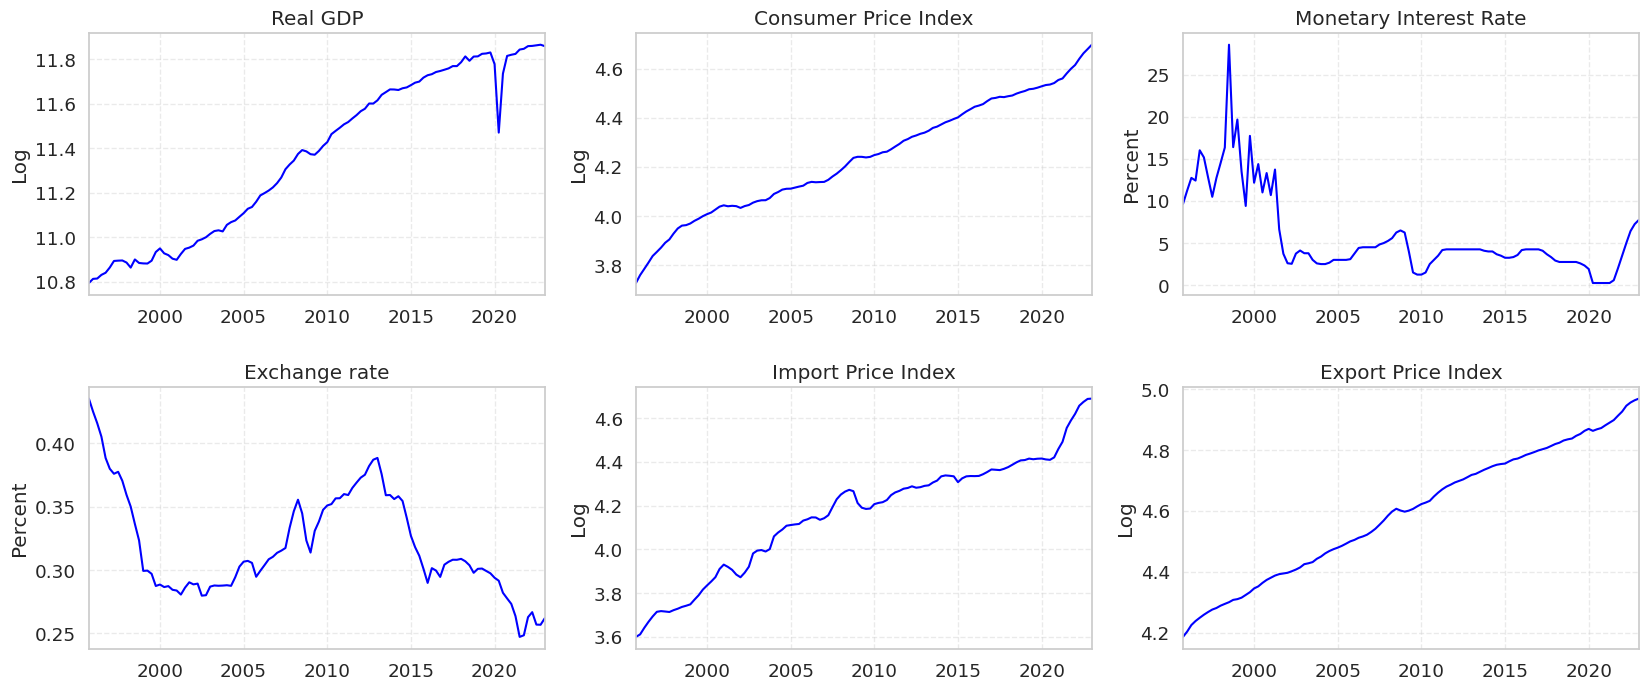

In [15]:
import seaborn as sns

# Configuración de estilo y tamaño de fuente
sns.set(style='whitegrid', font_scale=1.2)

# Crear figura y ejes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

plt.subplots_adjust(hspace=0.35, wspace=0.20)

# Obtener nombres de columnas

var_names = ['Real GDP', 'Consumer Price Index', 'Monetary Interest Rate',
             'Exchange rate', 'Import Price Index', 'Export Price Index']

kk = 0
# Generar gráficos

for colname, ax in zip(result.columns, axs.ravel()):
    if colname not in ['ner', 'mpr']:
      np.log(result[colname]).plot(ax=ax, label=colname, color='blue', linewidth=1.5)
      ax.set_ylabel('Log')
    else:
      result[colname].plot(ax=ax, label=colname, color='blue', linewidth=1.5)
      ax.set_ylabel('Percent')

    ax.set_title(var_names[kk] )
    #ax.set_xlabel('Years')
    ax.grid(True, linestyle='--', alpha=0.4)

    kk+=1

# Guardar el gráfico en alta resolución (300 DPI)
#fig.savefig(path + 'figures/graph_levels.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()


In [16]:
#Convert data in percentage changes
result_fd = result.copy()  # first difference

# Convert all series except 'mpr' to percentage changes
for ii in result_fd.columns:
    if ii != 'mpr':  # Skip 'mpr'
        result_fd[ii] = result_fd[ii].pct_change(1).mul(100)  # we lose 1 observation


In [17]:
result_fd.dropna(inplace=True)

In [18]:
### Tools for unit root tests

import warnings

# Suprimir advertencias
warnings.filterwarnings("ignore", category=FutureWarning)

def unit_root_table(DF, nmaxlags):
    table = []

    X = np.arange(1, len(DF) + 1)  # add trend
    X = sm.add_constant(X)  # add constant
    ColNames = ['TREND', 'CONSTANT']

    X = pd.DataFrame(X, columns=ColNames, index=DF.index)

    for column in DF:
        pvalues = sm.OLS(DF[column], X).fit().pvalues

        if (pvalues.iloc[1] <= 0.01) & (pvalues.iloc[0] >= 0.01):  # only constant
            typemodel = 'c'
        elif ((pvalues.iloc[1] <= 0.01) & (pvalues.iloc[0] <= 0.01)) | ((pvalues.iloc[1] >= 0.01) & (pvalues.iloc[0] <= 0.01)):  # constant and trend
            typemodel = 'ct'
        else:
            typemodel = 'c'  # collapse to the most simple case, constant.

        radf = adfuller(DF[column], regression=typemodel, autolag='AIC', maxlag=nmaxlags)
        rza = zivot_andrews(DF[column], regression=typemodel, autolag='AIC', maxlag=nmaxlags)
        rpp = PhillipsPerron(DF[column], trend=typemodel, test_type="rho", lags=nmaxlags)
        rkpss = KPSS(DF[column], trend=typemodel, lags=nmaxlags)

        rpp = [rpp.stat, rpp.pvalue]
        rkpss = [rkpss.stat, rkpss.pvalue]
        lags = radf[2]  # show lags calculated by dicky fuller test
        breakdate = rza[4]  # show break date got from zivot and andrews test

        test = []
        for j in [radf, rza, rpp, rkpss]:  # for loop to calculate stars and t-stas for all four tests
            if j == rkpss:  ## The null hypothesis for the test is that the data is stationary (kpss test in this case).
                if j[1] <= 0.01:
                    test.append(str(round(j[0], 2)))

                elif j[1] <= 0.05:
                    test.append(str(round(j[0], 2)) + '*')

                elif j[1] <= 0.01:
                    test.append(str(round(j[0], 2)) + '**')
                else:
                    test.append(str(round(j[0], 2)) + '***')

            else:  ## The null hypothesis for the remain tests are that the data is non-stationary.
                if j[1] <= 0.01:
                    test.append(str(round(j[0], 2)) + '***')

                elif j[1] <= 0.05:
                    test.append(str(round(j[0], 2)) + '**')

                elif j[1] <= 0.1:
                    test.append(str(round(j[0], 2)) + '*')
                else:
                    test.append(str(round(j[0], 2)))

        results = np.concatenate(([column, typemodel, lags, DF.index[breakdate]], test))
        table.append(results)

    # Sorting table:
    ColNames = ['variable', 'tm', 'lags', 'breakdate', 'adf', 'za', 'pp', 'kpss']
    unit_root_tab = pd.DataFrame(table, columns=ColNames)

    return unit_root_tab


In [19]:
### Large sample: 1995-Q1 2019-Q4
# unit root test results for data in levels
ur_levels = unit_root_table(result.copy(), nmaxlags=6)
# unit root test results for data in first differences
ur_fd     = unit_root_table(result_fd.copy(), nmaxlags=6)

ur_total = pd.merge(ur_levels, ur_fd, on='variable', suffixes=('_l', '_d'))[[ 'variable',  'tm_l', 'tm_d', 'lags_l', 'lags_d', 'breakdate_l', 'breakdate_d',
                                                                              'adf_l', 'adf_d', 'za_l', 'za_d', 'pp_l', 'pp_d', 'kpss_l', 'kpss_d']]
ur_total

,variable,tm_l,tm_d,lags_l,lags_d,breakdate_l,breakdate_d,adf_l,adf_d,za_l,za_d,pp_l,pp_d,kpss_l,kpss_d
0,gdp,ct,c,2,2,2010-03-31,2013-12-31,-2.86,-8.25***,-3.55,-8.43***,-24.77**,-101.8***,0.2*,0.08***
1,cpi,ct,ct,1,0,2019-03-31,2002-03-31,0.4,-4.7***,-2.0,-5.81***,2.72,-29.03**,0.31,0.18*
2,mpr,ct,ct,6,6,2001-06-30,2001-06-30,-1.61,-1.57,-5.34**,-6.11***,-20.5*,-19.54*,0.23,0.23
3,ner,ct,c,1,1,2009-03-31,2013-03-31,-2.38,-6.45***,-4.04,-7.94***,-7.5,-58.95***,0.19*,0.23***
4,ipi,ct,ct,1,5,2018-12-31,2018-12-31,-2.36,-4.51***,-4.16,-5.79***,-4.49,-40.91***,0.12***,0.13***
5,epi,ct,ct,1,5,2018-09-30,2014-09-30,-1.66,-4.95***,-3.28,-5.63***,-1.75,-40.52***,0.23,0.08***


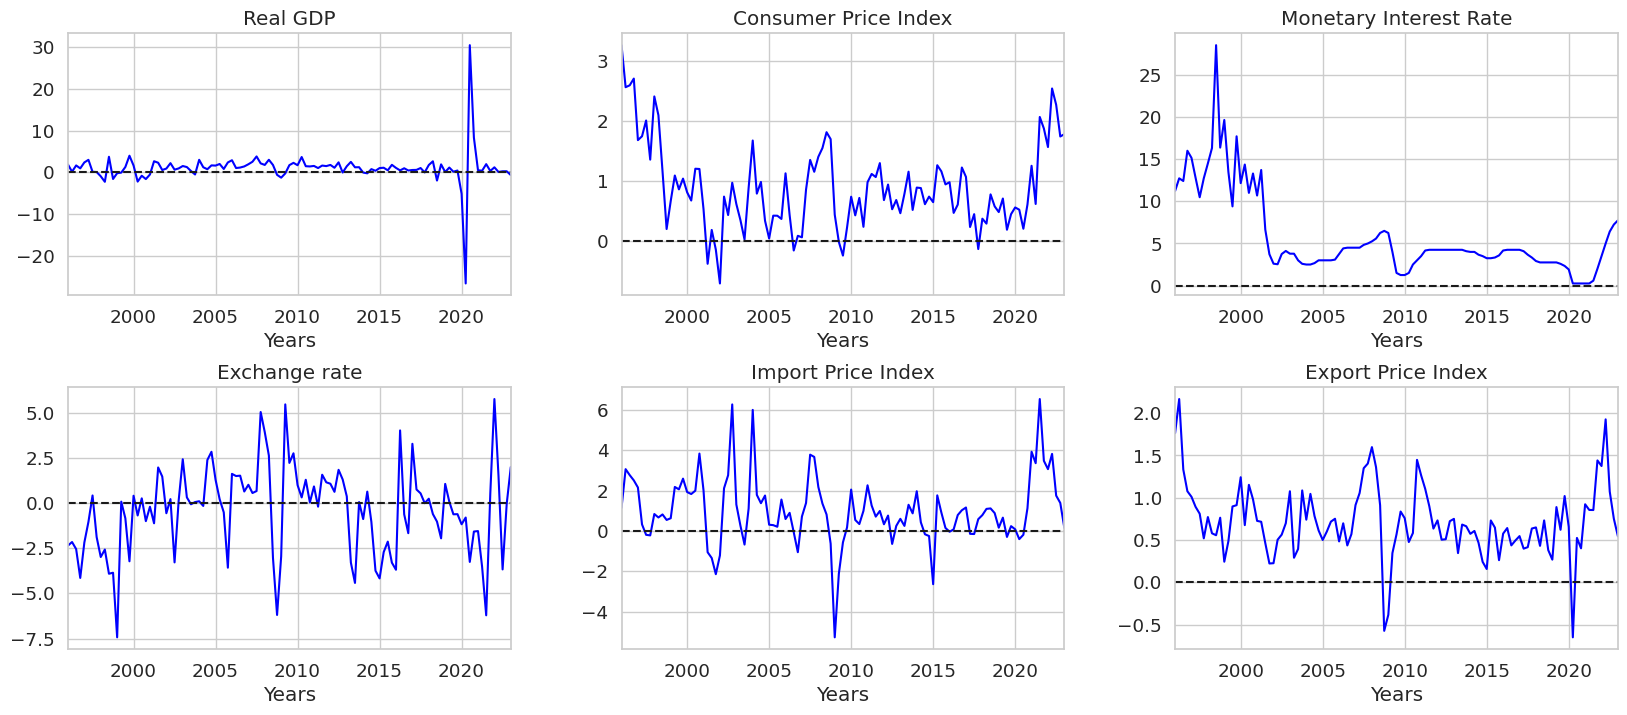

In [20]:
### Graph
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
plt.subplots_adjust(hspace=0.35, wspace = 0.25)

kk=0
for colname1,ax in zip(result_fd.columns, axs.ravel()):
    result_fd[colname1].plot(ax=ax,label=colname1,color='blue', linewidth=1.5);
    ax.axhline(y=0,color='k',linestyle='--'); ax.grid(1); ax.set_xlabel('Years')

    ax.set_title(var_names[kk] ); kk+=1

#fig.savefig(path + 'figures/graph_first_diff.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
# result_fd.to_excel(path + 'worked/data_Peru.xlsx')

# Making a linear regression model

In [22]:
path = "/content/drive/MyDrive/Python/ERPT/Outputs/"

In [23]:
data        = pd.read_excel(path +  "/Regressions.xlsx", index_col=0)
data.index  = pd.date_range(start='2000-09',freq='M',periods=len(data))

In [24]:
data

,rw_erpt_ipi,rw_erpt_cpi,fevd_dd,fevd_ds,fevd_mp,fevd_eer,fevd_gs,fevd_gd,vol_cpi,vol_ipi,...,L1_D_fevd_gd,L1_D_vol_er,L1_D_vol_ipi,L1_D_vol_cpi,L1_D_sv_er,L1_D_sv_ipi,L1_D_sv_cpi,L1_D_open,L1_D_impcomp,trend
2000-09-30,0.014017,-0.127061,0.110983,0.088780,0.121065,0.121128,0.140757,0.082523,0.114477,0.134441,...,-0.007371,-0.035791,0.252468,0.400159,0.022928,0.048208,0.021217,0.022364,0.043537,1
2000-10-31,0.379171,0.512757,0.096665,0.081677,0.135321,0.117250,0.146546,0.086258,0.114346,0.117729,...,0.108299,0.764943,0.000193,-0.012329,-0.019226,0.149462,-0.005300,-0.046922,0.036427,2
2000-11-30,0.287392,0.146430,0.100409,0.087717,0.139091,0.120339,0.148359,0.075188,0.113919,0.084685,...,0.045259,-0.056244,-0.124305,-0.001144,0.080942,0.225899,0.001738,0.129080,0.002703,3
2000-12-31,0.444244,0.314346,0.104515,0.075721,0.124051,0.123221,0.159539,0.072824,0.189359,0.124360,...,-0.128335,0.141157,-0.280679,-0.003737,-0.021745,-0.090419,0.013630,-0.018433,-0.058230,4
2001-01-31,0.152765,-0.035518,0.098064,0.081118,0.136766,0.128994,0.140823,0.083496,0.199861,0.124943,...,-0.031441,-0.008856,0.468497,0.662223,0.042388,0.012878,-0.010163,-0.085842,0.044227,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-10-31,-0.002089,0.083694,0.122110,0.141102,0.110370,0.120333,0.100440,0.087978,0.053422,0.049536,...,0.041121,0.014777,0.067859,-0.243016,-0.021698,-0.016835,0.003335,0.015859,-0.010080,74
2006-11-30,-0.001414,0.096492,0.117369,0.129694,0.110781,0.117801,0.102102,0.097701,0.051225,0.041292,...,-0.001508,-0.040142,-0.108270,0.025863,0.120237,0.051228,0.002463,-0.024566,-0.011487,75
2006-12-31,-0.002670,0.092354,0.124050,0.130761,0.136448,0.113874,0.099689,0.089677,0.047432,0.023609,...,0.110521,-0.585299,-0.166426,-0.041129,0.007021,0.051581,-0.004075,0.003357,-0.005308,76
2007-01-31,-0.001724,0.093116,0.135578,0.127296,0.131727,0.123748,0.098941,0.081876,0.027707,0.024656,...,-0.082131,-0.225915,-0.428243,-0.074034,-0.088233,-0.053066,-0.009433,-0.029052,-0.038052,77


In [25]:
pip install Stargazer

In [26]:
#############
import statsmodels.formula.api as smf
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer


## ejecutar un modelo de regresion lineal

* Modelo OLS donde los errores son corregidos por la metolodia West-tey
* El método Westerlund y Tey (West-Tey) es una técnica estadística utilizada para corregir errores estándar y estadísticos en el análisis de regresión cuando se presentan problemas de dependencia serial o autocorrelación en los residuos del modelo.

In [27]:
### With lagged dependent variable
structural_variables  = ' + 1  + vol_er.shift(1) + open.shift(1)'
vol_ipi               = ' + vol_ipi.shift(1) + trend'
###                     y ~ x1 + x2 + x3 ....
FORMULA_DD_IPI   = 'rw_erpt_ipi  ~ fevd_dd.shift(1)'   + vol_ipi
FORMULA_DS_IPI   = 'rw_erpt_ipi  ~ fevd_ds.shift(1)'   + vol_ipi
FORMULA_MP_IPI   = 'rw_erpt_ipi  ~ fevd_mp.shift(1)'   + vol_ipi
FORMULA_EER_IPI  = 'rw_erpt_ipi  ~ fevd_eer.shift(1)'  + vol_ipi
FORMULA_GS_IPI   = 'rw_erpt_ipi  ~ fevd_gs.shift(1)'   + vol_ipi
FORMULA_GD_IPI   = 'rw_erpt_ipi  ~ fevd_gd.shift(1)'   + vol_ipi


all_models = [FORMULA_DD_IPI, FORMULA_DS_IPI, FORMULA_MP_IPI, FORMULA_EER_IPI, FORMULA_GS_IPI, FORMULA_GD_IPI]

result_store = [] ## creando una lista que servira de almacen

for formulas in all_models:
      result = smf.ols(formula = formulas + structural_variables,  data = data).fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
      result_store.append(result)


## personalizar una tabla de resultados

In [28]:

stargazer = Stargazer(result_store)
#stargazer.title('Exchange rate pass-through determinants')
stargazer.custom_columns( ['DD','DS','MP','EER','GS','GD'],[1,1,1,1,1,1])
#stargazer.show_model_numbers(False)
stargazer.significant_digits(2)
stargazer.covariate_order(['fevd_dd.shift(1)', 'fevd_ds.shift(1)', 'fevd_mp.shift(1)', 'fevd_eer.shift(1)', 'fevd_gs.shift(1)','fevd_gd.shift(1)',
                           'vol_ipi.shift(1)', 'vol_er.shift(1)','open.shift(1)','trend'])
stargazer.rename_covariates(
      {'fevd_dd.shift(1)':   '\% demand shock',
       'fevd_ds.shift(1)':   '\% supply shock',
       'fevd_mp.shift(1)':   '\% monetary shock',
       'fevd_eer.shift(1)':  '\% exchange rate shock',
       'fevd_gs.shift(1)':   '\% global supply shock',
       'fevd_gd.shift(1)':   '\% global demand shock',
       'vol_ipi.shift(1)':   'Inflation volatility',
       'vol_er.shift(1)':    'Exchange rate volatility',
       'open.shift(1)':      'Trade openness',
       'trend':      'Trend'})

stargazer.show_degrees_of_freedom(False)
HTML(stargazer.render_html())

